In [1]:
# Importing libraries and initial configs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    PredefinedSplit,
)
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor


from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", 100, "display.max_rows", 100)


### Case Study #1

In [2]:
df = pd.read_csv("./data/loans_full_schema.csv")
df.head()


,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,0,38.0,2001,6,28,10,70795,38767,0,0,38.0,0,1250,2,5,5.0,10,0.0,0,2,11100,14,8,6,1,92.9,0,0,moving,individual,28000,60,14.07,652.53,C,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,0,NaN,1996,1,30,14,28800,4321,0,1,NaN,0,0,0,11,8.0,14,0.0,0,3,16500,24,14,4,0,100.0,0,1,debt_consolidation,individual,5000,36,12.61,167.54,C,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,0,28.0,2006,4,31,10,24193,16000,0,0,28.0,0,432,1,13,7.0,10,0.0,0,3,4300,14,8,6,0,93.5,0,0,other,individual,2000,36,17.09,71.40,D,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,0,NaN,2007,0,4,4,25400,4997,0,1,NaN,0,0,1,1,15.0,4,0.0,0,2,19400,3,3,2,0,100.0,1,0,debt_consolidation,individual,21600,36,6.72,664.19,A,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,0,NaN,2008,7,22,16,69839,52722,0,0,NaN,0,0,1,6,4.0,16,0.0,0,10,32700,20,15,13,0,100.0,0,0,credit_card,joint,23000,36,14.07,786.87,C,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


#### *The dataset - descriptions, overview, issues*

In [3]:
# Variables and their data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   emp_title                         9167 non-null   object 
 1   emp_length                        9183 non-null   float64
 2   state                             10000 non-null  object 
 3   homeownership                     10000 non-null  object 
 4   annual_income                     10000 non-null  float64
 5   verified_income                   10000 non-null  object 
 6   debt_to_income                    9976 non-null   float64
 7   annual_income_joint               1495 non-null   float64
 8   verification_income_joint         1455 non-null   object 
 9   debt_to_income_joint              1495 non-null   float64
 10  delinq_2y                         10000 non-null  int64  
 11  months_since_last_delinq          4342 non-null   float64
 12  earli

In [4]:
# Descriptive statistics of numerical attributes
df.describe()


,emp_length,annual_income,debt_to_income,annual_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees
count,9183.000000,1.000000e+04,9976.000000,1.495000e+03,1495.000000,10000.00000,4342.000000,10000.00000,10000.00000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,2285.000000,10000.0000,10000.000000,10000.000000,10000.000000,8729.000000,10000.000000,9682.0,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.930306,7.922215e+04,19.308192,1.279146e+05,19.979304,0.21600,36.760709,2001.29000,1.95820,22.679600,11.40440,1.836062e+05,51049.063100,0.013800,0.167100,46.112473,0.0001,184.334000,2.663600,4.376100,7.340703,11.379600,0.0,0.0001,3.595300,27357.410300,13.030000,8.095000,5.230500,1.383100,94.648990,0.043300,0.123800,16361.922500,43.272000,12.427524,476.205323,14458.916610,2494.234773,1894.448466,599.666781,0.119516
std,3.703734,6.473429e+04,15.004851,7.016838e+04,8.054781,0.68366,21.634939,7.79551,2.38013,11.885439,5.86828,1.876327e+05,53636.731172,0.126535,0.687768,21.748021,0.0100,2206.389859,2.935387,3.158583,5.981590,5.859705,0.0,0.0100,2.434689,26570.164081,7.874713,4.906606,3.327623,1.717274,9.155059,0.593852,0.337172,10301.956759,11.029877,5.001105,294.851627,9964.561865,3958.230365,3884.407175,517.328062,1.813468
min,0.000000,0.000000e+00,0.000000,1.920000e+04,0.320000,0.00000,1.000000,1963.00000,0.00000,2.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,2.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,14.300000,0.000000,0.000000,1000.000000,36.000000,5.310000,30.750000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,4.500000e+04,11.057500,8.683350e+04,14.160000,0.00000,19.000000,1997.00000,0.00000,14.000000,7.00000,5.159375e+04,19185.500000,0.000000,0.000000,29.000000,0.0000,0.000000,1.000000,2.000000,2.000000,7.000000,0.0,0.0000,2.000000,10000.000000,7.000000,5.000000,3.000000,0.000000,92.600000,0.000000,0.000000,8000.000000,36.000000,9.430000,256.040000,6679.065000,928.700000,587.100000,221.757500,0.000000
50%,6.000000,6.500000e+04,17.570000,1.130000e+05,19.720000,0.00000,34.000000,2003.00000,1.00000,21.000000,10.00000,1.146670e+05,36927.000000,0.000000,0.000000,47.000000,0.0000,0.000000,2.000000,4.000000,6.000000,10.000000,0.0,0.0000,3.000000,19500.000000,11.000000,7.000000,5.000000,1.000000,100.000000,0.000000,0.000000,14500.000000,36.000000,11.980000,398.420000,12379.495000,1563.300000,984.990000,446.140000,0.000000
75%,10.000000,9.500000e+04,25.002500,1.515455e+05,25.500000,0.00000,53.000000,2006.00000,3.00000,29.000000,14.00000,2.675500e+05,65421.000000,0.000000,0.000000,63.000000,0.0000,0.000000,3.000000,6.000000,11.000000,14.000000,0.0,0.0000,5.000000,36100.000000,17.000000,10.000000,7.000000,2.000000,100.000000,0.000000,0.000000,24000.000000,60.000000,15.050000,644.690000,20690.182500,2616.005000,1694.555000,825.420000,0.000000
max,10.000000,2.300000e+06,469.090000,1.100000e+06,39.980000,13.00000,118.000000,2015.00000,29.00000,87.000000,51.00000,3.386034e+06,942456.000000,3.000000,52.

In [5]:
# Checking for duplicates
df.duplicated().any()

False

In [6]:
# Checking the proportion of nulls in the dataframe
nulls = pd.DataFrame(
    {
        "Null Values": df.isna().sum(),
        "Percentage Null Values": (df.isna().sum() / len(df)).apply(
            lambda x: "{:.2%}".format(x)
        ),
    }
)
nulls


,Null Values,Percentage Null Values
emp_title,833,8.33%
emp_length,817,8.17%
state,0,0.00%
homeownership,0,0.00%
annual_income,0,0.00%
verified_income,0,0.00%
debt_to_income,24,0.24%
annual_income_joint,8505,85.05%
verification_income_joint,8545,85.45%
debt_to_income_joint,8505,85.05%


In [7]:
# Count of unique values for loan term
df["term"].value_counts()


36    6970
60    3030
Name: term, dtype: int64

In [8]:
# Count of unique values for num_accounts_120d_past_due
df["num_accounts_120d_past_due"].value_counts()

0.0    9682
Name: num_accounts_120d_past_due, dtype: int64

In [9]:
# Count of unique values for num_accounts_30d_past_due
df["num_accounts_30d_past_due"].value_counts()

0    9999
1       1
Name: num_accounts_30d_past_due, dtype: int64

In [10]:
# Count of unique values for current_accounts_delinq
df["current_accounts_delinq"].value_counts()

0    9999
1       1
Name: current_accounts_delinq, dtype: int64

The dataset contains records of loans that were offered and taken up through Lending Club. It has 10000 unique observations, each corresponding to one loan taken up. It has 55 features corresponding to various attributes related to the credit risk of a customer.

The loan terms in this dataset have two unique values, thus only 36 and 60 month loan terms were offered. The attribute `num_accounts_120d_past_due` in this dataset has only values populated 0, or nulls. Both `num_accounts_30d_past_due` and `current_accounts_delinq` also do not have any variation in the unique values. `annual_income_joint`, `verification_income_joint`, `debt_to_income_joint`, `months_since_last_delinq` and `months_since_90d_late` have very prpoportions of nulls.

#### *Visualizations - Exploratory analysis*

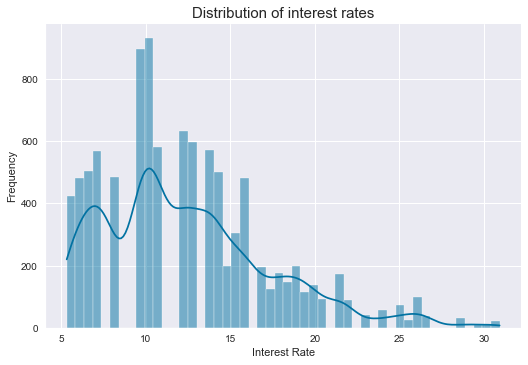

In [11]:
sns.set_style("darkgrid")

# Checking the distribution of the interest rates
sns.displot(data=df, x="interest_rate", bins=50, kde=True, height=5, aspect=1.5)
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.title("Distribution of interest rates", fontsize=15)
plt.show()


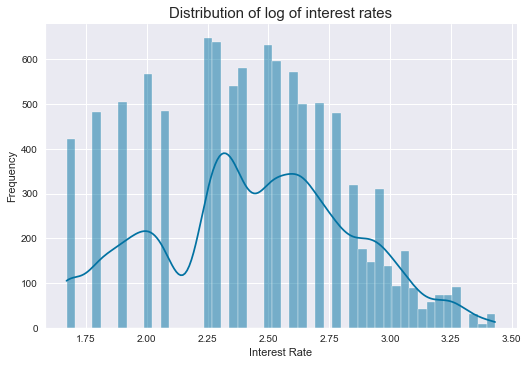

In [12]:
# Checking the distribution of the log of interest rates
sns.displot(np.log(df["interest_rate"]), bins=50, kde=True, height=5, aspect=1.5)
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.title("Distribution of log of interest rates", fontsize=15)
plt.show()


Looking at the distribution of interest rates, we observe that the distribution is skewed to the right. We also observe the log transformation of this variable which is less skewed, but not perfectly normally distributed.

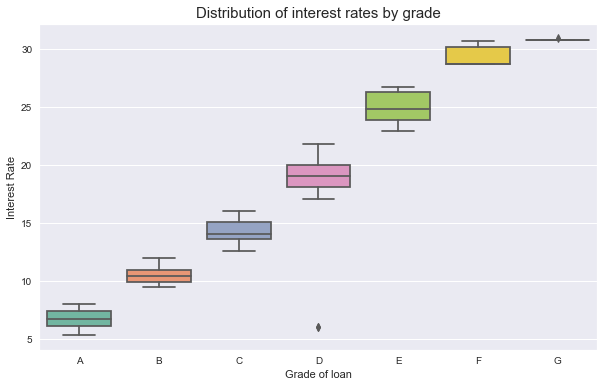

In [13]:
# Checking the distribution of interest rates by grade
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df,
    x="grade",
    y="interest_rate",
    order=["A", "B", "C", "D", "E", "F", "G"],
    palette="Set2",
)
plt.xlabel("Grade of loan")
plt.ylabel("Interest Rate")
plt.title("Distribution of interest rates by grade", fontsize=15)
plt.show()


The grade of the loan, from 'A' to 'G', shows a nicely linear relationship with the interest rate, as can be seen from the graph above.

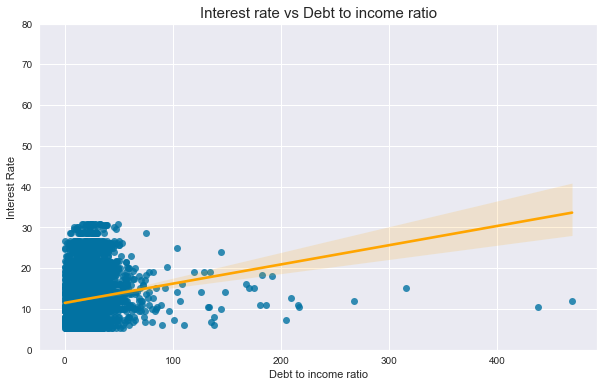

In [14]:
# Comparing debt_to_income and interest_rate
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x="debt_to_income",
    y="interest_rate",
    line_kws={"color": "orange"},
    fit_reg=True,
)
plt.xlabel("Debt to income ratio")
plt.ylim(0, 80)
plt.ylabel("Interest Rate")
plt.title("Interest rate vs Debt to income ratio", fontsize=15)
plt.show()


Debt-to-income is a good indicator of the financial health of an individual, with higher values signalling more risk. While most values are within the 100% threshold, we observe some values where individuals have potentially more debt than income. The interest rate slopes up with this attribute.

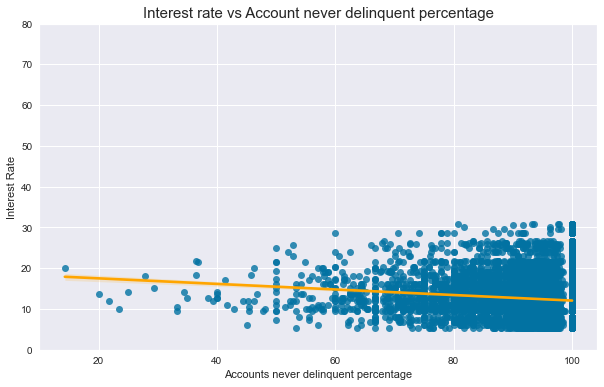

In [15]:
# Comparing account_never_delinq_percent and interest_rate
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x="account_never_delinq_percent",
    y="interest_rate",
    line_kws={"color": "orange"},
    fit_reg=True,
)
plt.xlabel("Accounts never delinquent percentage")
plt.ylabel("Interest Rate")
plt.ylim(0, 80)
plt.title("Interest rate vs Account never delinquent percentage", fontsize=15)
plt.show()


The percentage of never delinquent accounts is another good indicator for credit risk. Here we observe that the higher the number of never delinquent accounts held by an individual, the lower interest rate he gets offered.

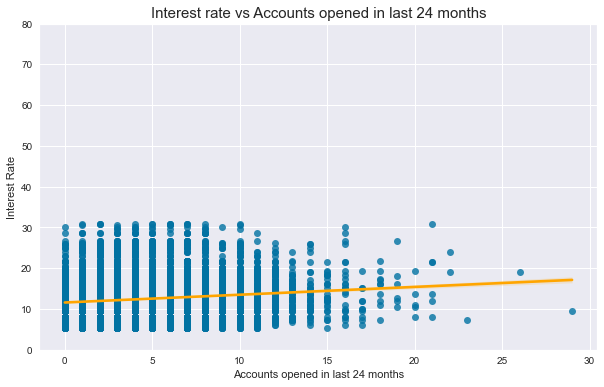

In [16]:
# Comparing accounts_opened_24m and interest_rate
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x="accounts_opened_24m",
    y="interest_rate",
    line_kws={"color": "orange"},
    fit_reg=True,
)
plt.xlabel("Accounts opened in last 24 months")
plt.ylabel("Interest Rate")
plt.ylim(0, 80)
plt.title("Interest rate vs Accounts opened in last 24 months", fontsize=15)
plt.show()


The higher the number of accounts opened in the last 24 months, could be an indicator of how credit-hungry an individual is. The trend for interest rates slopes up with this attribute, as can be seen in the plot above.

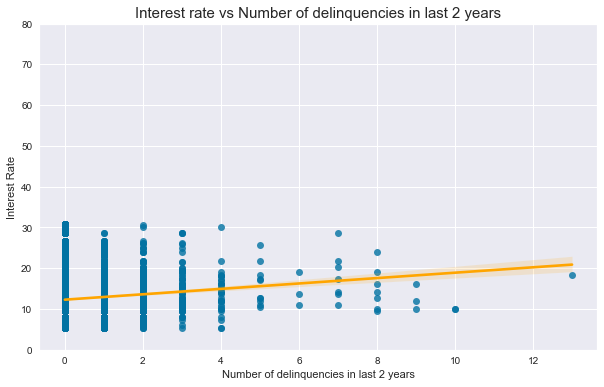

In [17]:
# Comparing delinq_2y and interest_rate
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x="delinq_2y",
    y="interest_rate",
    line_kws={"color": "orange"},
    fit_reg=True,
)
plt.xlabel("Number of delinquencies in last 2 years")
plt.ylabel("Interest Rate")
plt.ylim(0, 80)
plt.title("Interest rate vs Number of delinquencies in last 2 years", fontsize=15)
plt.show()


If there are a higher number of delinquencies reported against an individual in the preceding two years, it could be an indicator of higher risk. The interest rates tend to go up when this increases.

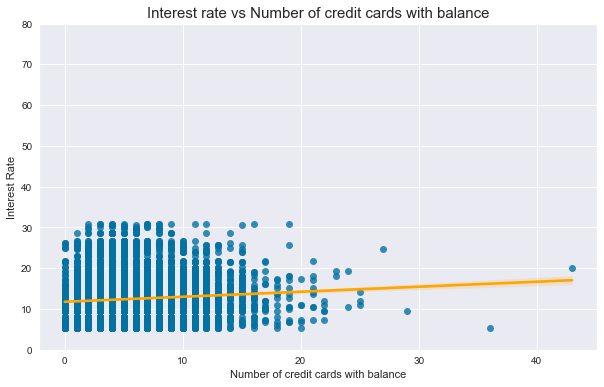

In [18]:
# Comparing num_cc_carrying_balance and interest_rate
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x="num_cc_carrying_balance",
    y="interest_rate",
    line_kws={"color": "orange"},
    fit_reg=True,
)
plt.xlabel("Number of credit cards with balance")
plt.ylabel("Interest Rate")
plt.ylim(0, 80)
plt.title("Interest rate vs Number of credit cards with balance", fontsize=15)
plt.show()


The number of credit cards carrying balance is a good indicator of active credit usage by a customer. Higher amounts may indicate higher risk, and hence, we observe that interest rates increase with higher numbers of actively used credit cards.

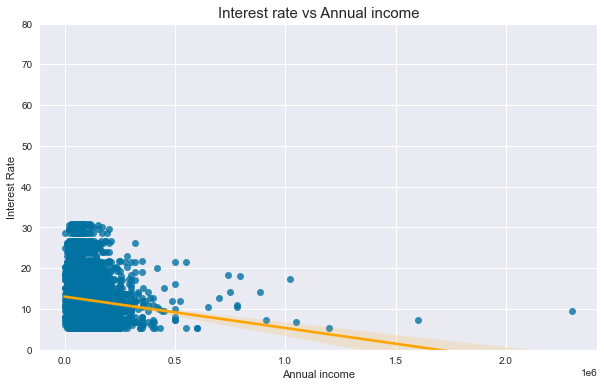

In [19]:
# Comparing annual_income and interest_rate
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df,
    x="annual_income",
    y="interest_rate",
    line_kws={"color": "orange"},
    fit_reg=True,
)
plt.xlabel("Annual income")
plt.ylabel("Interest Rate")
plt.ylim(0, 80)
plt.title("Interest rate vs Annual income", fontsize=15)
plt.show()


We observe that the interest rates decerease with higher values of income, which is to be expected, as offering loans to higher income inviduals is not risky.

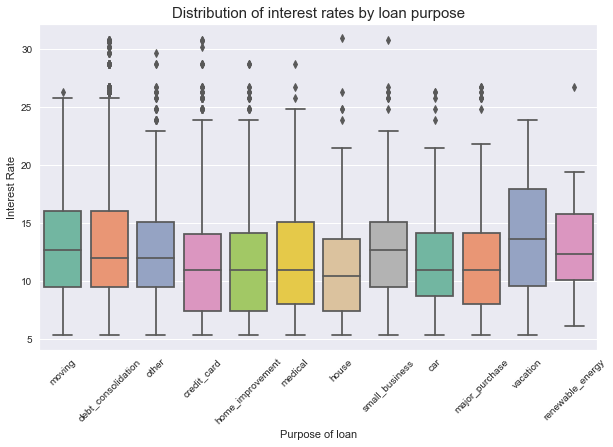

In [20]:
# Checking the distribution of loan purpose by grade
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x="loan_purpose", y="interest_rate", palette="Set2")
plt.xlabel("Purpose of loan")
plt.xticks(rotation=45)
plt.ylabel("Interest Rate")
plt.title("Distribution of interest rates by loan purpose", fontsize=15)
plt.show()


We observe here that there is significant variation in the interest rates by the purpose for which the loan is taken. Mortgages and loans for medical purposes have low interest rates, while loans for businesses have higher rates.

#### *Pre-processing the dataset*

In [21]:
# Dropping columns populated with a single value throughout
df.drop(columns=["num_accounts_120d_past_due", "num_accounts_30d_past_due", "current_accounts_delinq"], inplace=True)


In [22]:
# Dropping columns where proportion of nulls is greater than 50%
df.drop(
    columns=nulls.loc[nulls["Null Values"] / len(df) >= 0.5].index.tolist(),
    inplace=True,
)
print("Dataframe shape after dropping columns with more than 50% null values:", df.shape)


Dataframe shape after dropping columns with more than 50% null values: (10000, 47)


In [23]:
# Separating features into categorical and numerical attributes
df_cat = df.select_dtypes(include=["object"]).copy()
df_num = df.select_dtypes(include=["int64", "float64"]).copy()


In [24]:
# Using mode imputation to impute nulls for the categorical features
df_cat.fillna(df_cat.mode().iloc[0], inplace=True)


In [25]:
# Using multiple imputation to impute nulls for the numeric features
# This estimates the nulls from the other features, it models each feature with missing values as a function of other features

imputer = IterativeImputer(random_state=0)
df_impute = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns)
df_impute.head()


,emp_length,annual_income,debt_to_income,delinq_2y,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_amount,term,interest_rate,installment,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,3.0,90000.0,18.01,0.0,2001.0,6.0,28.0,10.0,70795.0,38767.0,0.0,0.0,1250.0,2.0,5.0,5.0,10.0,2.0,11100.0,14.0,8.0,6.0,1.0,92.9,0.0,0.0,28000.0,60.0,14.07,652.53,27015.86,1999.33,984.14,1015.19,0.0
1,10.0,40000.0,5.04,0.0,1996.0,1.0,30.0,14.0,28800.0,4321.0,0.0,1.0,0.0,0.0,11.0,8.0,14.0,3.0,16500.0,24.0,14.0,4.0,0.0,100.0,0.0,1.0,5000.0,36.0,12.61,167.54,4651.37,499.12,348.63,150.49,0.0
2,3.0,40000.0,21.15,0.0,2006.0,4.0,31.0,10.0,24193.0,16000.0,0.0,0.0,432.0,1.0,13.0,7.0,10.0,3.0,4300.0,14.0,8.0,6.0,0.0,93.5,0.0,0.0,2000.0,36.0,17.09,71.40,1824.63,281.80,175.37,106.43,0.0
3,1.0,30000.0,10.16,0.0,2007.0,0.0,4.0,4.0,25400.0,4997.0,0.0,1.0,0.0,1.0,1.0,15.0,4.0,2.0,19400.0,3.0,3.0,2.0,0.0,100.0,1.0,0.0,21600.0,36.0,6.72,664.19,18853.26,3312.89,2746.74,566.15,0.0
4,10.0,35000.0,57.96,0.0,2008.0,7.0,22.0,16.0,69839.0,52722.0,0.0,0.0,0.0,1.0,6.0,4.0,16.0,10.0,32700.0,20.0,15.0,13.0,0.0,100.0,0.0,0.0,23000.0,36.0,14.07,786.87,21430.15,2324.65,1569.85,754.80,0.0


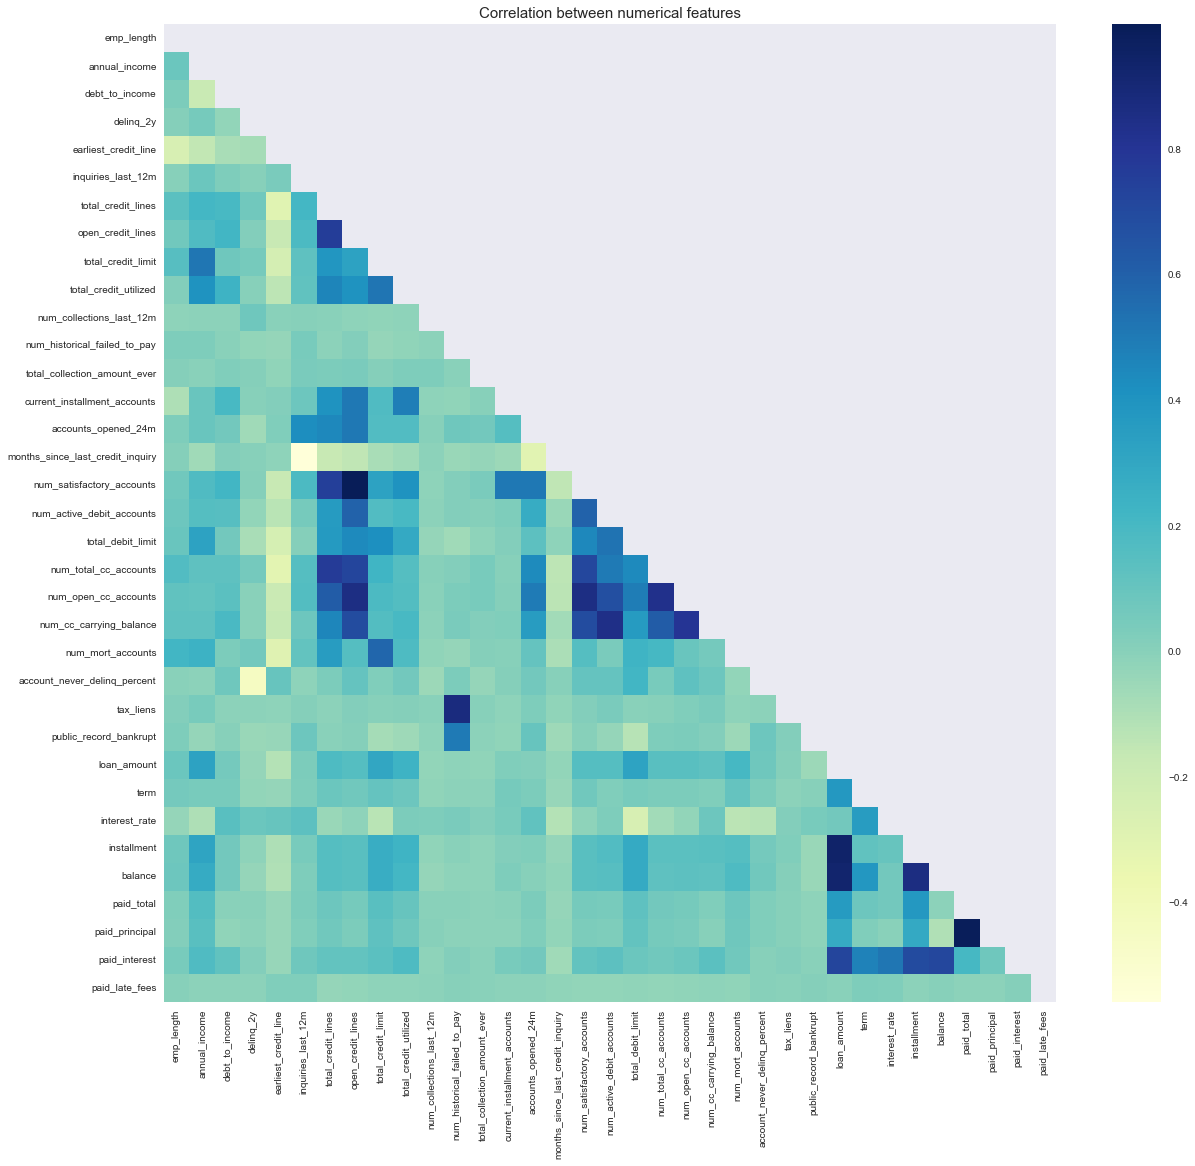

In [26]:
# Checking for presence of collinearity among the numerical features
fig = plt.figure(figsize=(20, 18))

corr = df_impute.corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    # annot=True,
    # fmt=".2%",
    cmap="YlGnBu",
    mask=np.triu(corr),
)
plt.title("Correlation between numerical features", fontsize=15)
plt.show();


In [27]:
# corr.to_csv("./corr.csv")

In [28]:
corr_cols_to_drop = [
    "total_credit_lines",
    "num_satisfactory_accounts",
    # "num_accounts_30d_past_due",
    "num_active_debit_accounts",
    "num_open_cc_accounts",
    "num_total_cc_accounts",
    "tax_liens",
    "installment",
    "balance",
    "paid_interest",
    "paid_late_fees",
    "paid_principal",
    "paid_total",
    "num_cc_carrying_balance",
]


In [29]:
df_subset = df_impute.drop(columns=corr_cols_to_drop)
print("Dataframe shape after dropping columns with high correlation:", df_subset.shape)

Dataframe shape after dropping columns with high correlation: (10000, 22)


An alternate visualization can be found in the file `./artifacts/corr.xlsx`. A threshold of 70% is used to determine which correlated features to drop. For similar pairs like `total_credit_lines` and `open_credit_lines`, or the attribute corresponding to `open_*` is shortlisted as that is a more accurate indicator of the active credit behaviour of the individual. All attributes which correspond to behaviour of the loan post its disbursement (`paid_principal`, `balance`, `paid_total`, etc.) are dropped, as through this analysis, we seek to determine if it is possible to develop a predictive model that can accurately price a loan, given various credit attributes of an individual.

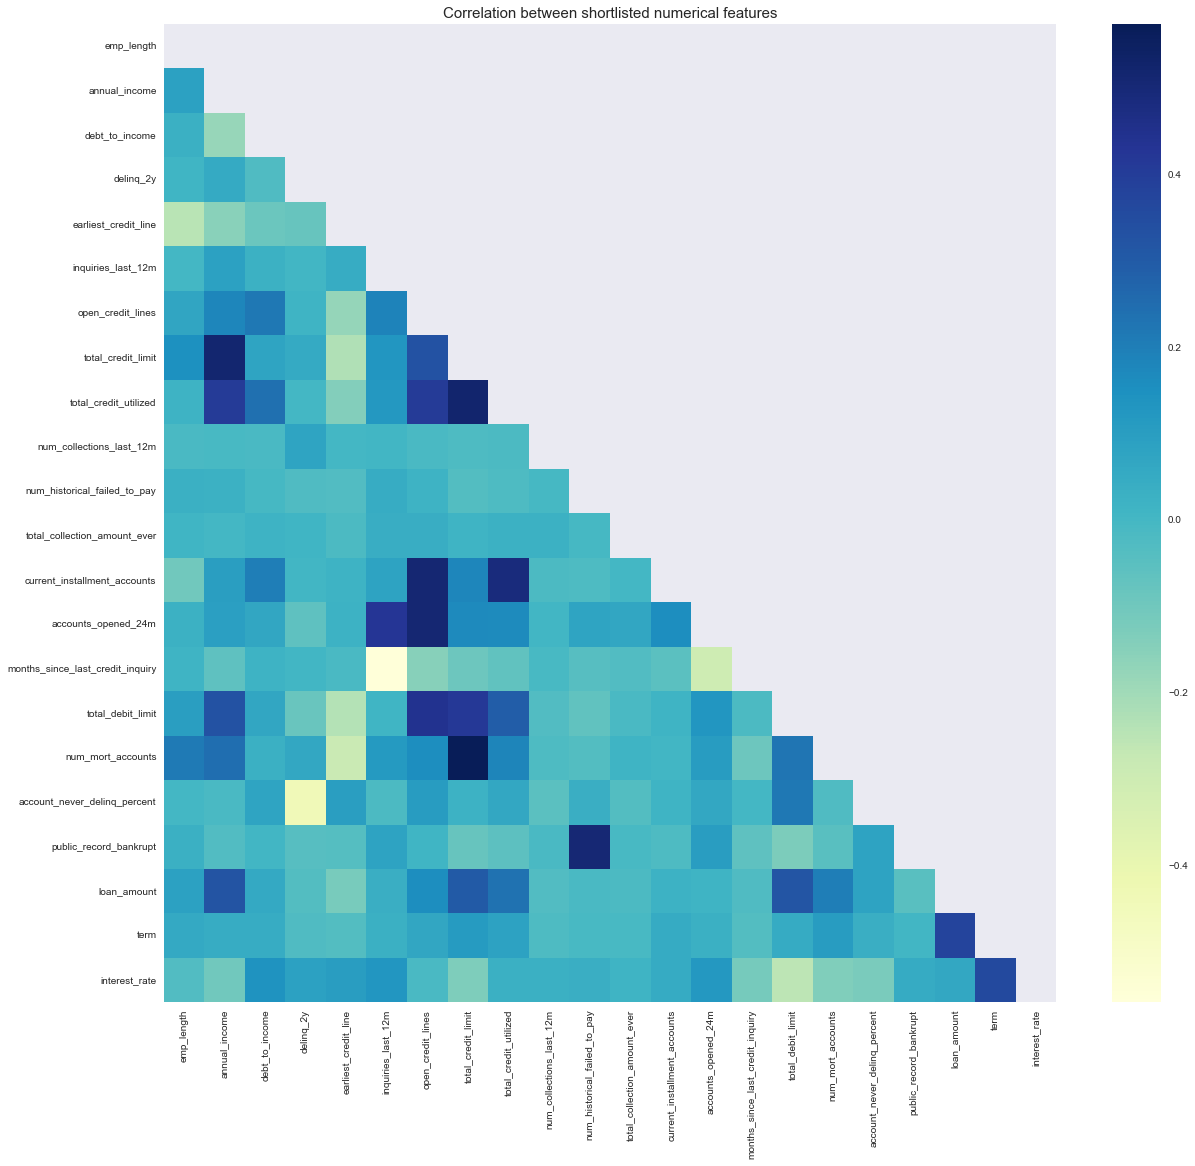

In [30]:
# Re-checking correlation heatmap
fig = plt.figure(figsize=(20, 18))
corr2 = df_subset.corr()
sns.heatmap(
    corr2,
    xticklabels=corr2.columns.values,
    yticklabels=corr2.columns.values,
    # annot=True,
    # fmt=".2%",
    cmap="YlGnBu",
    mask=np.triu(corr2),
)
plt.title("Correlation between shortlisted numerical features", fontsize=15)
plt.show();


In [31]:
# Pre-processing on the categorical features
df_cat["emp_title"].value_counts().index[:30]


Index(['manager', 'owner', 'teacher', 'driver', 'sales', 'registered nurse',
       'rn', 'supervisor', 'truck driver', 'office manager', 'president',
       'general manager', 'project manager', 'director', 'engineer',
       'operations manager', 'nurse', 'sales manager', 'software engineer',
       'technician', 'owner ', 'accountant', 'account manager', 'analyst',
       'machine operator', 'mechanic', 'server', 'ceo', 'foreman',
       'consultant'],
      dtype='object')

We observe here that the numer of unique values corresponding to this attribute is very high, often with variations of the same title. To avoid extremely high dimensionality while modeling, we drop this variable from further consideration. Some additonal categorical features listed below are also dropped, as these do not add any value in the prediction of interest rates.

In [32]:
cat_cols_to_drop = [
    "emp_title",
    "issue_month",
    "loan_status",
    "disbursement_method",
    "sub_grade",
    "state"
]


In [33]:
df_cat.drop(columns=cat_cols_to_drop, inplace=True)
df_cat.shape


(10000, 6)

In [34]:
df_cat.head()


,homeownership,verified_income,loan_purpose,application_type,grade,initial_listing_status
0,MORTGAGE,Verified,moving,individual,C,whole
1,RENT,Not Verified,debt_consolidation,individual,C,whole
2,RENT,Source Verified,other,individual,D,fractional
3,RENT,Not Verified,debt_consolidation,individual,A,whole
4,RENT,Verified,credit_card,joint,C,whole


In [35]:
# Using one-hot encoding for the shortlisted categorical features

ohe = OneHotEncoder(handle_unknown="ignore")
df_cat_ohe = pd.DataFrame(
    ohe.fit_transform(df_cat).toarray(), columns=ohe.get_feature_names_out()
)
df_cat_ohe.head()


,homeownership_MORTGAGE,homeownership_OWN,homeownership_RENT,verified_income_Not Verified,verified_income_Source Verified,verified_income_Verified,loan_purpose_car,loan_purpose_credit_card,loan_purpose_debt_consolidation,loan_purpose_home_improvement,loan_purpose_house,loan_purpose_major_purchase,loan_purpose_medical,loan_purpose_moving,loan_purpose_other,loan_purpose_renewable_energy,loan_purpose_small_business,loan_purpose_vacation,application_type_individual,application_type_joint,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,initial_listing_status_fractional,initial_listing_status_whole
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
# Merging back the pre-processed numerical and categorical attributes together
df_full = pd.concat([df_subset, df_cat_ohe], axis=1)
print("Dataframe shape after merging numerical and categorical features:", df_full.shape)


Dataframe shape after merging numerical and categorical features: (10000, 51)


In [37]:
# Re-checking any null values
df_full.isna().any().any()


False

In [38]:
# Train-test split
train, test = train_test_split(df_full, test_size=0.3, random_state=0)
X_train = train.drop(columns=["interest_rate"])
y_train = train["interest_rate"]
X_test = test.drop(columns=["interest_rate"])
y_test = test["interest_rate"]


In [39]:
# Further splitting train dataset to training and validation
np.random.seed(8642)

mask = np.random.rand(X_train.shape[0]) < 0.8

X_tr = X_train[mask]
X_val = X_train[~mask]

y_tr = y_train[mask]
y_val = y_train[~mask]


In [40]:
# Create a predefined train/test split for GridSearchCV (to be used later)
validation_fold = np.concatenate((-1 * np.ones(len(y_tr)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)


##### Fitting Linear Regression

In [41]:
# Fitting linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print("On training set: {:.2%}".format(lin_reg.score(X_train, y_train)))
print("On test set: {:.2%}".format(lin_reg.score(X_test, y_test)))


On training set: 95.20%
On test set: 95.40%


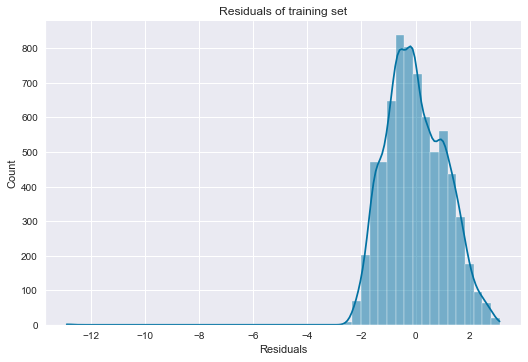

In [42]:
# Histogram of residuals
y_train_pred = lin_reg.predict(X_train)
residuals = y_train - y_train_pred

sns.displot(residuals, bins=50, kde=True, height=5, aspect=1.5)
plt.xlabel("Residuals")
plt.title("Residuals of training set")
plt.show();

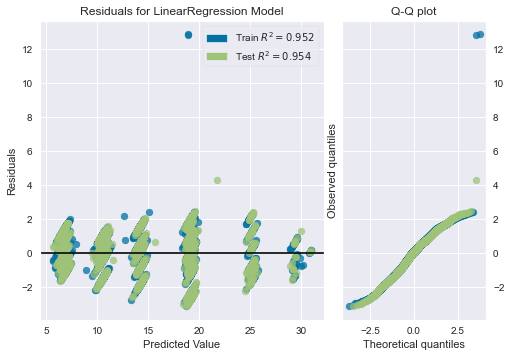

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [43]:
# Visualizing residuals
visualizer = ResidualsPlot(lin_reg, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [44]:
# Fitting linear regression with log transform of the target variable
log_lin_reg = LinearRegression()
log_lin_reg.fit(X_train, np.log(y_train))

print("On training set: {:.2%}".format(log_lin_reg.score(X_train, np.log(y_train))))
print("On test set: {:.2%}".format(log_lin_reg.score(X_test, np.log(y_test))))


On training set: 94.14%
On test set: 94.26%


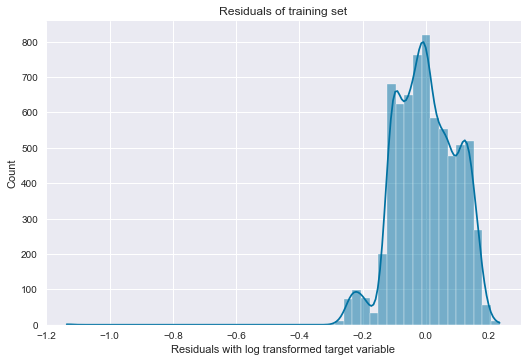

In [45]:
# Visualizing residuals
y_train_pred = log_lin_reg.predict(X_train)
residuals = np.log(y_train) - y_train_pred

sns.displot(residuals, bins=50, kde=True, height=5, aspect=1.5)
plt.xlabel("Residuals with log transformed target variable")
plt.title("Residuals of training set")
plt.show();

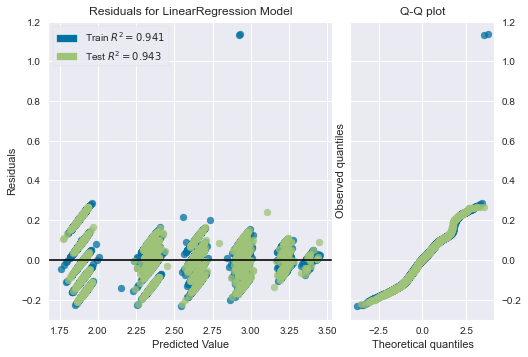

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [46]:
visualizer = ResidualsPlot(log_lin_reg, hist=False, qqplot=True)
visualizer.fit(X_train, np.log(y_train))
visualizer.score(X_test, np.log(y_test))
visualizer.show()


##### Fitting linear regression with Lasso regularization

In [47]:
# Fitting Lasso
lass = Lasso(random_state=0)
lass.fit(X_train, y_train)

print("On training set: {:.2%}".format(lass.score(X_tr, y_tr)))
print("On training set: {:.2%}".format(lass.score(X_val, y_val)))
print("On test set: {:.2%}".format(lass.score(X_test, y_test)))


On training set: 26.43%
On training set: 27.52%
On test set: 27.61%


In [48]:
# Performing grid search to find the best hyperparameters
param_grid = {
    "alpha": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    "selection": ["cyclic", "random"],
}

lasso_cv = Lasso(random_state=0, max_iter=10000)
gridsearch = GridSearchCV(
    lasso_cv,
    cv=train_val_split,
    param_grid=param_grid,
    # n_iter=10000,
    scoring="r2",
    n_jobs=-2,
    # random_state=2,
)
search = gridsearch.fit(X_train, y_train)
print(
    "The best learning parameters obtained out of the randomized search are: \n",
    search.best_params_,
)
print(
    "The best score obtained out of the randomized search is: \n",
    search.best_score_,
)


The best learning parameters obtained out of the randomized search are: 
 {'alpha': 0.001, 'selection': 'cyclic'}
The best score obtained out of the randomized search is: 
 0.946195208514141


In [49]:
# Fitting model again with best parameters obtained from grid search
lass = Lasso(random_state=0, max_iter=10000, alpha=0.001, selection="cyclic")
lass.fit(X_train, y_train)

print("On training set: {:.2%}".format(lass.score(X_train, y_train)))
# print("On validation set: {}".format(lass.score(X_val, y_val)))
print("On test set: {:.2%}".format(lass.score(X_test, y_test)))


On training set: 95.20%
On test set: 95.41%


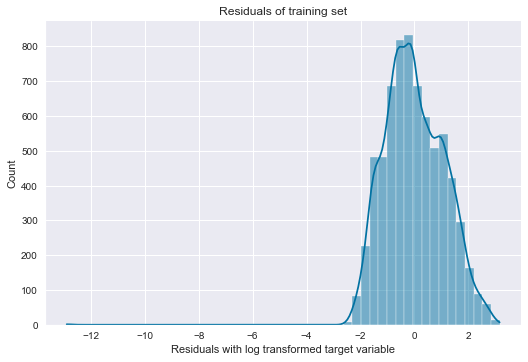

In [50]:
y_train_pred = lass.predict(X_train)
residuals = y_train - y_train_pred

sns.displot(residuals, bins=50, kde=True, height=5, aspect=1.5)
plt.xlabel("Residuals with log transformed target variable")
plt.title("Residuals of training set")
plt.show();

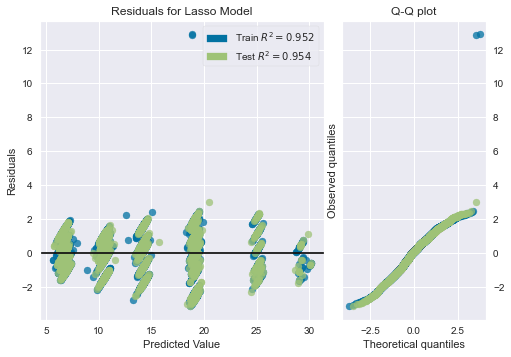

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [51]:
visualizer = ResidualsPlot(lass, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [52]:
# Fitting lasso with log transform of the target variable, with hyperparameters obtained from grid search
log_lass = Lasso(random_state=0, max_iter=10000, alpha=0.001, selection="random")
log_lass.fit(X_train, np.log(y_train))

print("On training set: {:.2%}".format(log_lass.score(X_train, np.log(y_train))))
# print("On validation set: {}".format(lass.score(X_val, y_val)))
print("On test set: {:.2%}".format(log_lass.score(X_test, np.log(y_test))))


On training set: 93.78%
On test set: 93.97%


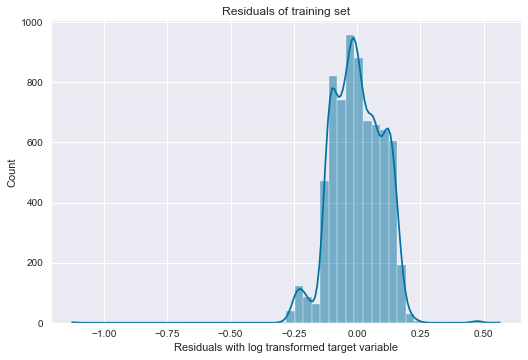

In [53]:
y_train_pred = log_lass.predict(X_train)
residuals = np.log(y_train) - y_train_pred

sns.displot(residuals, bins=50, kde=True, height=5, aspect=1.5)
plt.xlabel("Residuals with log transformed target variable")
plt.title("Residuals of training set")
plt.show();

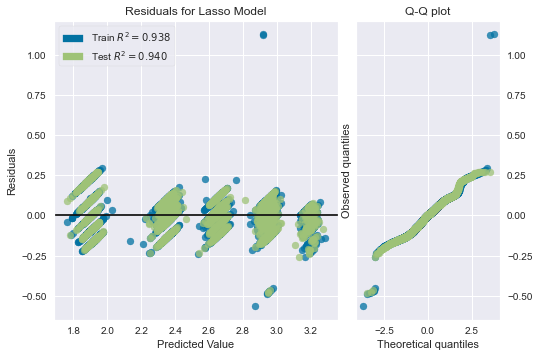

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [54]:
visualizer = ResidualsPlot(log_lass, hist=False, qqplot=True)
visualizer.fit(X_train, np.log(y_train))
visualizer.score(X_test, np.log(y_test))
visualizer.show()


As can be seen from the plots above, the following iterations are performed:

1. Linear Regression
1. Linear Regression with log transformed target
1. Linear Regression with Lasso regularization
1. Linear Regression with Lasso regularization and with log transformed target

Both Lasso models are fit using tuned parameters obtained from the grid search algorithm. The grid search algorithm cross validates concurrently on the validation dataset to decide the model with the best performance. The metric used to decide between models is the R-squared metric, which explains the amount of variance explained by the model. Once the tuned parameters are obatined, the model is refit on all the training and validation data and tested on the test dataset.

For iterations (1) and (3), we observe that the distribution of the residuals is very skewed. This is further confirmed by the QQ plot, which leads us to conclude the the assumption of normality of residuals is violated. Further, looking at residual plots, we can also observe that the assumption of independence of observations is also violated.

For iterations (2) and (4), we also observe that the assumption of normality of residuals is violated, from the distribution of residuals as well as the QQ plots. Further, in these iterations, we observe that the assumptions of independence of observations, as well as the assumptions of homoscedasticity are violated, as can be observed by the presence of patterns amongst the residuals.

Thus, the linear regression model results tell us that the assumptions are violated and hence, should not be used for making decisions.





##### Fitting a Random Forest Regressor

In [55]:
# Fitting random forest
rf = RandomForestRegressor(
    n_estimators=1000, max_depth=25, max_features=3
)
rf.fit(X_train, y_train)

print("On training set: {:.2%}".format(rf.score(X_train, y_train)))
print("On test set: {:.2%}".format(rf.score(X_test, y_test)))


On training set: 98.26%
On test set: 87.57%


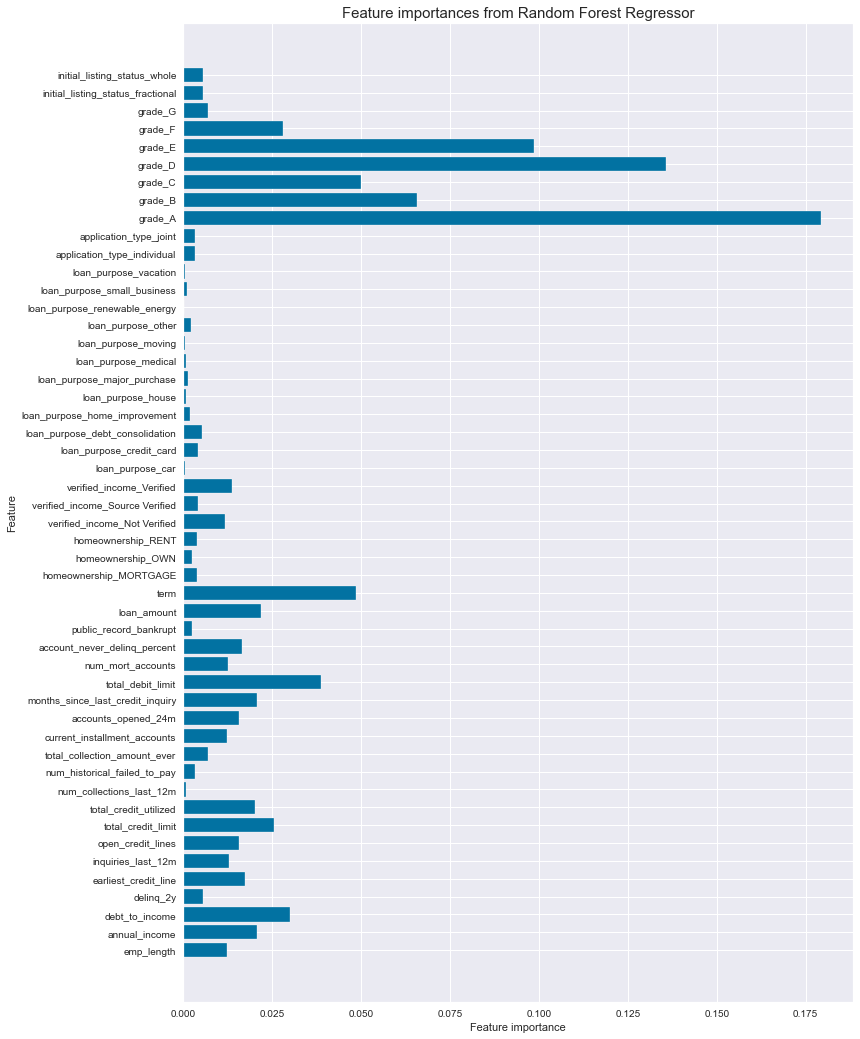

In [56]:
importance = rf.feature_importances_
plt.figure(figsize=(12, 18))

# plot feature importance
plt.barh(X_train.columns, importance)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Feature importances from Random Forest Regressor", fontsize = 15)
plt.show()


We observe that the Random Forest Regressor has achieves an R-squared score of ~88% on the test dataset. Grade, loan term and loan amount can be observed as some of the most important features, as observed from the plot above. Since this algorithm uses multiple trees and averages out the prediction value for the target, the bias can be greatly reduced. However, this regressor can quickly get complex if we increase the number of trees. 

##### Limitations and Future Work

One-hot encoding leads to increased dimensionality of the dataset, resulting in sparse matrices of coefficients. Tree-based algorithms are a good way to deal with this, and different tree-based regressors with bagging can be performed to check for better model performance.

Scaling and normalization of features can be carried out, although tree-based algorithms work well without scaling. Outliers need to be properly analyzed, since these can significantly affects models like linear regression. 

For the `emp_title` attribute, we observed that there are many categories which are similar, for example, "registered nurse", "rn", and "nurse" could be collapsed into a single category. A simple NLP algorithm which leverages Levenshtein distances could be used to this end to reduce the number of unique values of this attribute. 